#Overview
This project is based on the dataset available at https://www.kaggle.com/c/tweet-sentiment-extraction/overview which is composed of about 20k tweets to train sentiment predictors.

#Imports

In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


#Data Importing

In [2]:
train = pd.read_csv("dataset.csv")

#Data Exploration

In [3]:
train.head(15)

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1
5,some shameless plugging for the best rangers f...,0
6,fun,2
7,soooo high,0
8,both of you,0
9,wow just became cooler,2


In [4]:
len(train)

27481

In [5]:
train['sentiment'].unique()

array([0, 1, 2])

In [6]:
train.groupby('sentiment').nunique()

,selected_text
sentiment,
0,11015
1,4998
2,4498


In [7]:
sentiment_map = {2 :'positive', 0 : 'neutral' , 1 : 'negative'}

In [8]:
train['sentiment'] = train['sentiment'].map(sentiment_map)

In [9]:
train.head()

,selected_text,sentiment
0,have responded if were going,neutral
1,sooo sad,negative
2,bullying me,negative
3,leave me alone,negative
4,sons of,negative


In [10]:
train.head()

,selected_text,sentiment
0,have responded if were going,neutral
1,sooo sad,negative
2,bullying me,negative
3,leave me alone,negative
4,sons of,negative


#Data Cleaning

In [11]:
train['selected_text'].isna().sum()

134

In [12]:
train['selected_text'].fillna('No Content', inplace=True)

In [13]:
def depure_data(data):

  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  data = url_pattern.sub(r'', data)

  data = re.sub('\S*@\S*\s', '', data)

  data = re.sub('\s+', ' ', data)

  data = re.sub("\'", "", data)

  return data

In [14]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
  temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['have responded if were going',
 'sooo sad',
 'bullying me',
 'leave me alone',
 'sons of']

In [15]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  #deacc=True removes punctuations

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [16]:
len(data_words)

27481

In [17]:
def detokenize(text):
  return TreebankWordDetokenizer().detokenize(text)

In [18]:
data = []
for i in range(len(data_words)):
  data.append(detokenize(data_words[i]))
print(data[:10])


['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of', 'some shameless plugging for the best rangers forum on earth', 'fun', 'soooo high', 'both of you', 'wow just became cooler']


In [19]:
data =np.array(data)

#Label Encoding

In [21]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
  if labels[i] == 'neutral':
    y.append(0)
  if labels[i] == 'negative':
    y.append(1)
  if labels[i] == 'positive':
    y.append(2)
y = np.array(y)
labels =tf.keras.utils.to_categorical(y, 3).astype("float32")
del y

In [22]:
len(labels)

27481

#Data Sequencing and splitting

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  398   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  373   10    3]
 [   0    0    0 ...   25  543    4]
 [   0    0    0 ... 2424  200  658]]


In [25]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print(len(X_train), len(X_test), len(y_train), len(y_test))

20610 6871 20610 6871


#Model Building

SimpleRNN Models

In [32]:
model10 = Sequential()
model10.add(layers.Embedding(max_words, 15))
model10.add(layers.SimpleRNN(15))
model10.add(layers.Dense(3, activation='softmax'))

model10.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model10.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto',save_weights_only=False, save_freq='epoch')
history = model10.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5964 - loss: 0.8953
Epoch 1: val_accuracy improved from -inf to 0.75986, saving model to best_model10.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.5967 - loss: 0.8949 - val_accuracy: 0.7599 - val_loss: 0.6121
Epoch 2/5
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7887 - loss: 0.5516
Epoch 2: val_accuracy improved from 0.75986 to 0.80716, saving model to best_model10.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.7888 - loss: 0.5516 - val_accuracy: 0.8072 - val_loss: 0.5090
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8258 - loss: 0.4753
Epoch 3: val_accuracy improved from 0.80716 to 0.81167, saving model to best_model10.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.8258 - loss: 0.4753 - val_accuracy: 0.8117 - val_loss: 0.4927
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8456 - loss: 0.4189
Epoch 4: val_accuracy improve

#Model Validation

In [33]:
best_model = keras.models.load_model("best_model10.keras")

In [34]:
test_loss, test_acc =best_model.evaluate(X_test, y_test, verbose=2)
print('Model Accuracy: ', test_acc)

215/215 - 3s - 15ms/step - accuracy: 0.8216 - loss: 0.4782
Model Accuracy:  0.8215689063072205


In [35]:
predictions = best_model.predict(X_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


#Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
print(matrix)

[[2428  161  145]
 [ 438 1478   50]
 [ 293  146 1732]]


<Axes: >

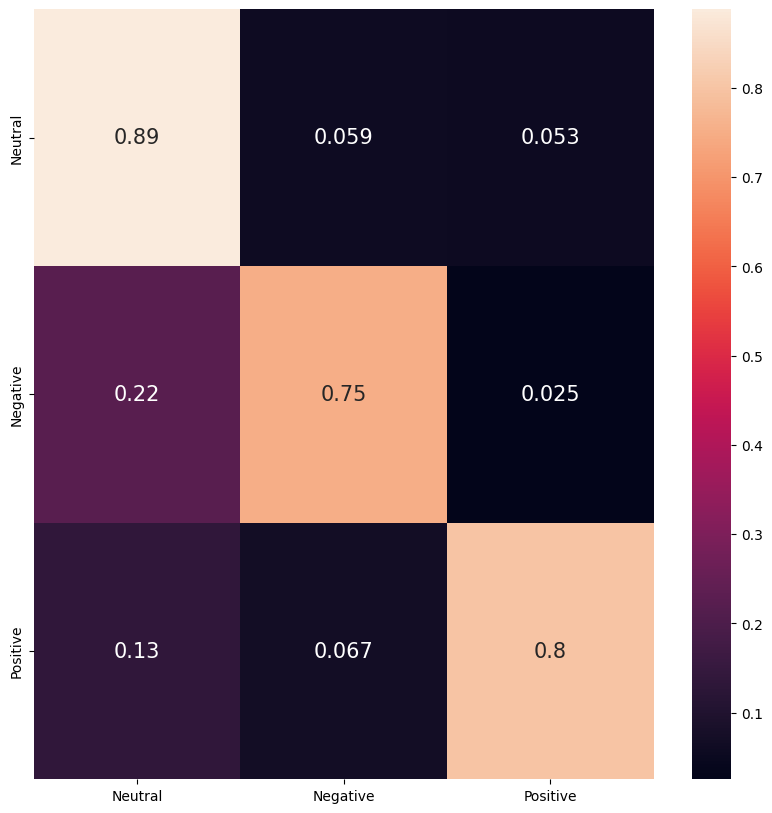

In [42]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index=['Neutral', 'Negative', 'Positive'], columns=['Neutral', 'Negative', 'Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1).values[:, np.newaxis]
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [43]:
sentiment = ['Neutral', 'Negative', 'Positive']

In [46]:
sequence = tokenizer.texts_to_sequences(["This experience has been really bad, i want a refund"])
test =pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


'Negative'

In [49]:
sequence = tokenizer.texts_to_sequences(["This project has been really good"])
test =pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


'Positive'

In [51]:
sequence = tokenizer.texts_to_sequences(["this is the best project i have ever done"])
test =pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'Positive'